# Notebook 5 - Terrain Constraints
---
This section introduces the yield reduction due to terrain slope, soil erosion, and Fournier Index (FI). The FI is based on the monthly precipitation (climate-related). These yield reduction factors will be applied to the maximum attainable yield. For detailed calculations for this section, please refer to the GAEZv4 documentation.
([Fischer et al., 2021](https://pure.iiasa.ac.at/id/eprint/17175/1/GAEZ4_model_documentation+app_20210415_withFAOstyles_covers.pdf))

Prepared by Geoinformatics Center, AIT

---

### Google drive connection
In this step, we will connect to Google Drive service and mount the drive where we will start our PyAEZ project

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)


Then, installing any additional python packages that required to run PyAEZ.
If working on your own PC/machine, these additional installation will vary depending on what is already installed in your Python library. 

In [ ]:
# 'Installing neccessary packages'
# !pip install gdal
# # !pip install pyaez==2.0.0

Now, we will import the specific Python packages we need for PyAEZ.

In [1]:
'''import supporting libraries'''
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
try:
    from osgeo import gdal
except:
    import gdal
import sys


Setting the working directory -- where our PyAEZ project is located.

In [2]:
'Set the working directory'
# Replace with path to your PyAEZv2 folder
work_dir = '/Volumes/GoogleDrive/My Drive/PyAEZv2_FINAL_DRAFT'
os.chdir(work_dir)
sys.path.append('./pyaez/')
!pwd

# Check whether the specified path exists or not
out_path = './data_output/NB1/'
isExist = os.path.exists(out_path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(out_path)
   print("The new directory is created!")


/Volumes/GoogleDrive/My Drive/PyAEZv2_FINAL_DRAFT


<hr>

## MODULE 5: TERRAIN CONSTRAINTS
Now, we will start executing the routines in Module 5


First, we initiate Module 5 Class instance by invoking the following commands:

In [3]:
'''importing library'''
import TerrainConstraints
terrain_constraints = TerrainConstraints.TerrainConstraints()

import UtilitiesCalc
obj_utilities = UtilitiesCalc.UtilitiesCalc()

### Import the required data as NumPy array
If read GeoTIFF file, use the command: 

*gdal.Open(r'**file_path**').ReadAsArray()*

In [4]:
'''reading climate and slope data'''

precipitation = np.load('./data_input/climate/precipitation.npy') # mm / day
slope= gdal.Open('./data_input/LAO_Slope.tif').ReadAsArray(); # Percentage Slope

In [5]:
'''Load the geographical data/rasters'''
mask_path = './data_input/LAO_Admin.tif'
mask = gdal.Open(mask_path).ReadAsArray()


Load the rainfall data and the terrain slope data into the Object Class ***terrain_constraints***

In [6]:
'''passing climate and slope data'''
terrain_constraints.setClimateTerrainData(precipitation, slope)

### Calculate Fournier Index (FI)
This function calculates Fournier Index (FI) based on the input monthly precipitation. FI is a simple index that indicates the potential of soil erosion based on monthly precipitation.

In [7]:
'''calculation of Fournier index'''

terrain_constraints.calculateFI()
fi = terrain_constraints.getFI()

In [8]:
'''Masking the result'''
fi = np.ma.masked_where(mask==0,fi)

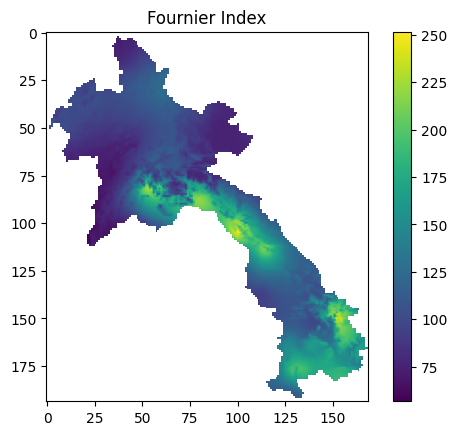

In [9]:
# visualization of result
plt.imshow(fi)
plt.title('Fournier Index')
plt.colorbar()
plt.savefig("./data_output/NB5/LAO_FournierIndex.png",bbox_inches='tight',dpi=300)
plt.show()

# saving the output as TIFF file
obj_utilities.saveRaster(mask_path, r'./data_output/NB5/LAO_Fournier_Index.tif', fi)


### Read the attainable yield map (after climate and soil constraints)

In [10]:
'''reading yield data'''
clim_soil_adj_yield_rain = gdal.Open(r'./data_output/NB4/LAO_clim_soil_adj_yield_rain.tif').ReadAsArray()  # rainfed
clim_soil_adj_yield_irr = gdal.Open(
    r'./data_output/NB4/LAO_clim_soil_adj_yield_irr.tif').ReadAsArray()  # irrigated
#-----------
# Masking
clim_soil_adj_yield_rain = np.ma.masked_where(mask==0,clim_soil_adj_yield_rain)
clim_soil_adj_yield_irr = np.ma.masked_where(mask==0,clim_soil_adj_yield_irr)

### Applying the terrain constraints

In [11]:
#  Applying the Terrain constraints
clim_soil_terr_adj_yield_rain = terrain_constraints.applyTerrainConstraints(
    clim_soil_adj_yield_rain, 'R')  # I: Irrigated, R: Rain-fed
clim_soil_terr_adj_yield_irr = terrain_constraints.applyTerrainConstraints(
    clim_soil_adj_yield_irr, 'I')  # I: Irrigated, R: Rain-fed

clim_soil_terr_adj_yield_rain_class = obj_utilities.classifyFinalYield(
    clim_soil_terr_adj_yield_rain)
clim_soil_terr_adj_yield_irr_class = obj_utilities.classifyFinalYield(
    clim_soil_terr_adj_yield_irr)


In [12]:
'''Masking the results'''
clim_soil_terr_adj_yield_rain = np.ma.masked_where(mask==0,clim_soil_terr_adj_yield_rain)
clim_soil_terr_adj_yield_irr = np.ma.masked_where(mask==0,clim_soil_terr_adj_yield_irr)
clim_soil_terr_adj_yield_rain_class = np.ma.masked_where(mask==0,clim_soil_terr_adj_yield_rain_class)
clim_soil_terr_adj_yield_irr_class = np.ma.masked_where(mask==0,clim_soil_terr_adj_yield_irr_class)

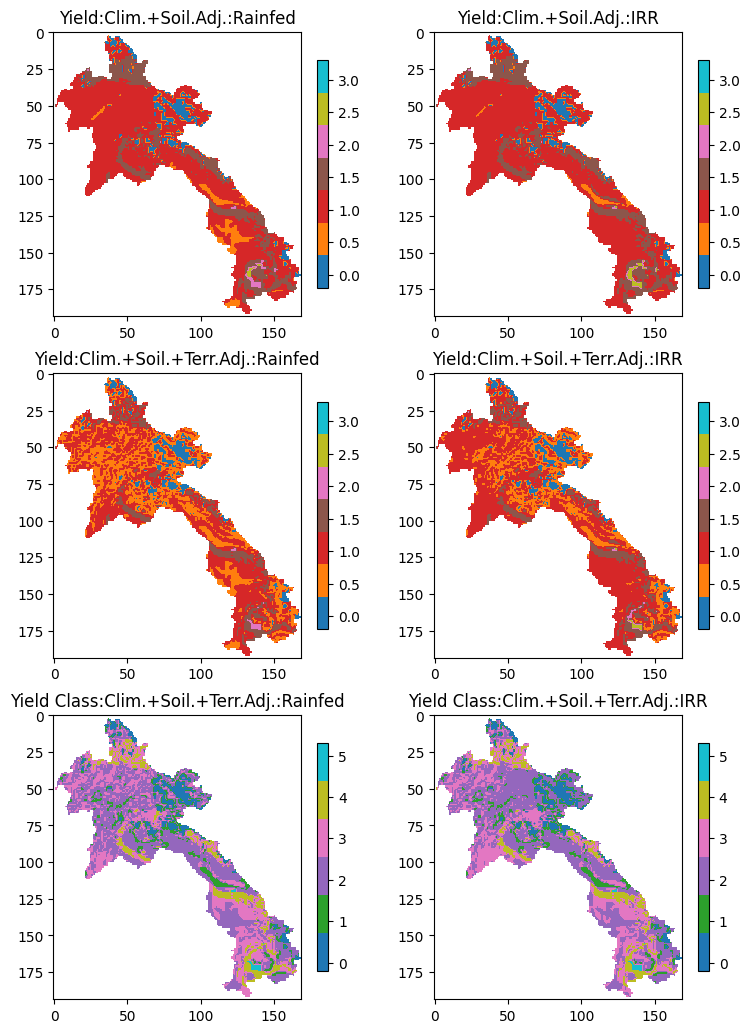

In [13]:
'''visualisng the output from Module 5 Terrain Constraints'''
plt.figure(figsize=(9, 17))
# --------------------
# Plot the Yield - climate + soil adjusted (Rainfed)
plt.subplot(4, 2, 1)
plt.imshow(clim_soil_adj_yield_rain,
           cmap=plt.get_cmap('tab10', 7),
           vmin=-0.2, vmax=3.3)
plt.title('Yield:Clim.+Soil.Adj.:Rainfed')
plt.colorbar(shrink=0.8)
# --------------------
# Plot the Yield - climate + soil adjusted (Irrigated)
plt.subplot(4, 2, 2)
plt.imshow(clim_soil_adj_yield_irr,
           cmap=plt.get_cmap('tab10', 7),
           vmin=-0.2, vmax=3.3)
plt.title('Yield:Clim.+Soil.Adj.:IRR')
plt.colorbar(shrink=0.8)
# --------------------
# Plot the Yield - climate+soil+terrain adjusted (Rainfed)
plt.subplot(4, 2, 3)
plt.imshow(clim_soil_terr_adj_yield_rain,
           cmap=plt.get_cmap('tab10', 7),
           vmin=-0.2, vmax=3.3)
plt.title('Yield:Clim.+Soil.+Terr.Adj.:Rainfed')
plt.colorbar(shrink=0.8)
# --------------------
# # Plot the Yield  - climate+soil+terrain adjusted (Irrigated)
plt.subplot(4, 2, 4)
plt.imshow(clim_soil_terr_adj_yield_irr,
           cmap=plt.get_cmap('tab10', 7),
           vmin=-0.2, vmax=3.3)
plt.title('Yield:Clim.+Soil.+Terr.Adj.:IRR')
plt.colorbar(shrink=0.8)
# --------------------
# Plot the Yield Class - climate+soil+terrain adjusted (Rainfed)
plt.subplot(4, 2, 5)
plt.imshow(clim_soil_terr_adj_yield_rain_class,
           cmap=plt.get_cmap('tab10', 6),
           vmin=-0.2, vmax=5.3)
plt.title('Yield Class:Clim.+Soil.+Terr.Adj.:Rainfed')
plt.colorbar(shrink=0.8)
# --------------------
# Plot the Yield Class- climate+soil+terrain adjusted (Irrigated)
plt.subplot(4, 2, 6)
plt.imshow(clim_soil_terr_adj_yield_irr_class,
           cmap=plt.get_cmap('tab10', 6),
           vmin=-0.2, vmax=5.3)
plt.title('Yield Class:Clim.+Soil.+Terr.Adj.:IRR')
plt.colorbar(shrink=0.8)
# --------------------

plt.savefig("./data_output/NB5/LAO_ClimSoilTerrainConstraints.png",
            bbox_inches='tight', dpi=300)
plt.show()


In [14]:
# saving the outputs as TIFF files
obj_utilities.saveRaster(mask_path,
                    r'./data_output/NB5/LAO_clim_soil_terr_adj_yield_rain.tif', clim_soil_terr_adj_yield_rain)
obj_utilities.saveRaster(mask_path,
                    r'./data_output/NB5/LAO_clim_soil_terr_adj_yield_irr.tif', clim_soil_terr_adj_yield_irr)

obj_utilities.saveRaster(mask_path,
                         r'./data_output/NB5/LAO_clim_soil_terr_adj_yield_rain_class.tif', clim_soil_terr_adj_yield_rain_class)
obj_utilities.saveRaster(mask_path,
                         r'./data_output/NB5/LAO_clim_soil_terr_adj_yield_irr_class.tif', clim_soil_terr_adj_yield_irr_class)


---

### END OF MODULE 5: TERRAIN CONSTRAINTS

---
